In [1]:
import numpy as np
import matplotlib.pylab as plt

from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
from funcs import *
import cooltools
import cooltools.lib.plotting
%matplotlib inline

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### params

In [206]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [100., 1.],
    'CTCF_offtime': [0.1, 1],
    'LEF_lifetime': [150, 150],
    'LEF_stalled_lifetime': [150, 150],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 100,
    'sites_per_monomer': 10,
    'monomers_per_replica': 10,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

In [176]:
monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
print(len(site_types))

100


In [177]:
# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}

site_types[sites_per_replica//2:] = typedict['strong_CTCF']
site_types[:sites_per_replica//2] = typedict['weak_CTCF']

In [178]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']

print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

1 0.1


In [179]:
# Create some CTCF boundary sites

CTCF_left_positions = np.array([15,30])
CTCF_right_positions = np.array([70, 85])

In [180]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)
trajectory_length = 175000
hist = []

for _ in range(trajectory_length):
    translocator.step()
    hist.append(translocator.LEFs.copy())

In [181]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset.reshape((-1, 2)), sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

### dynamic barriers

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


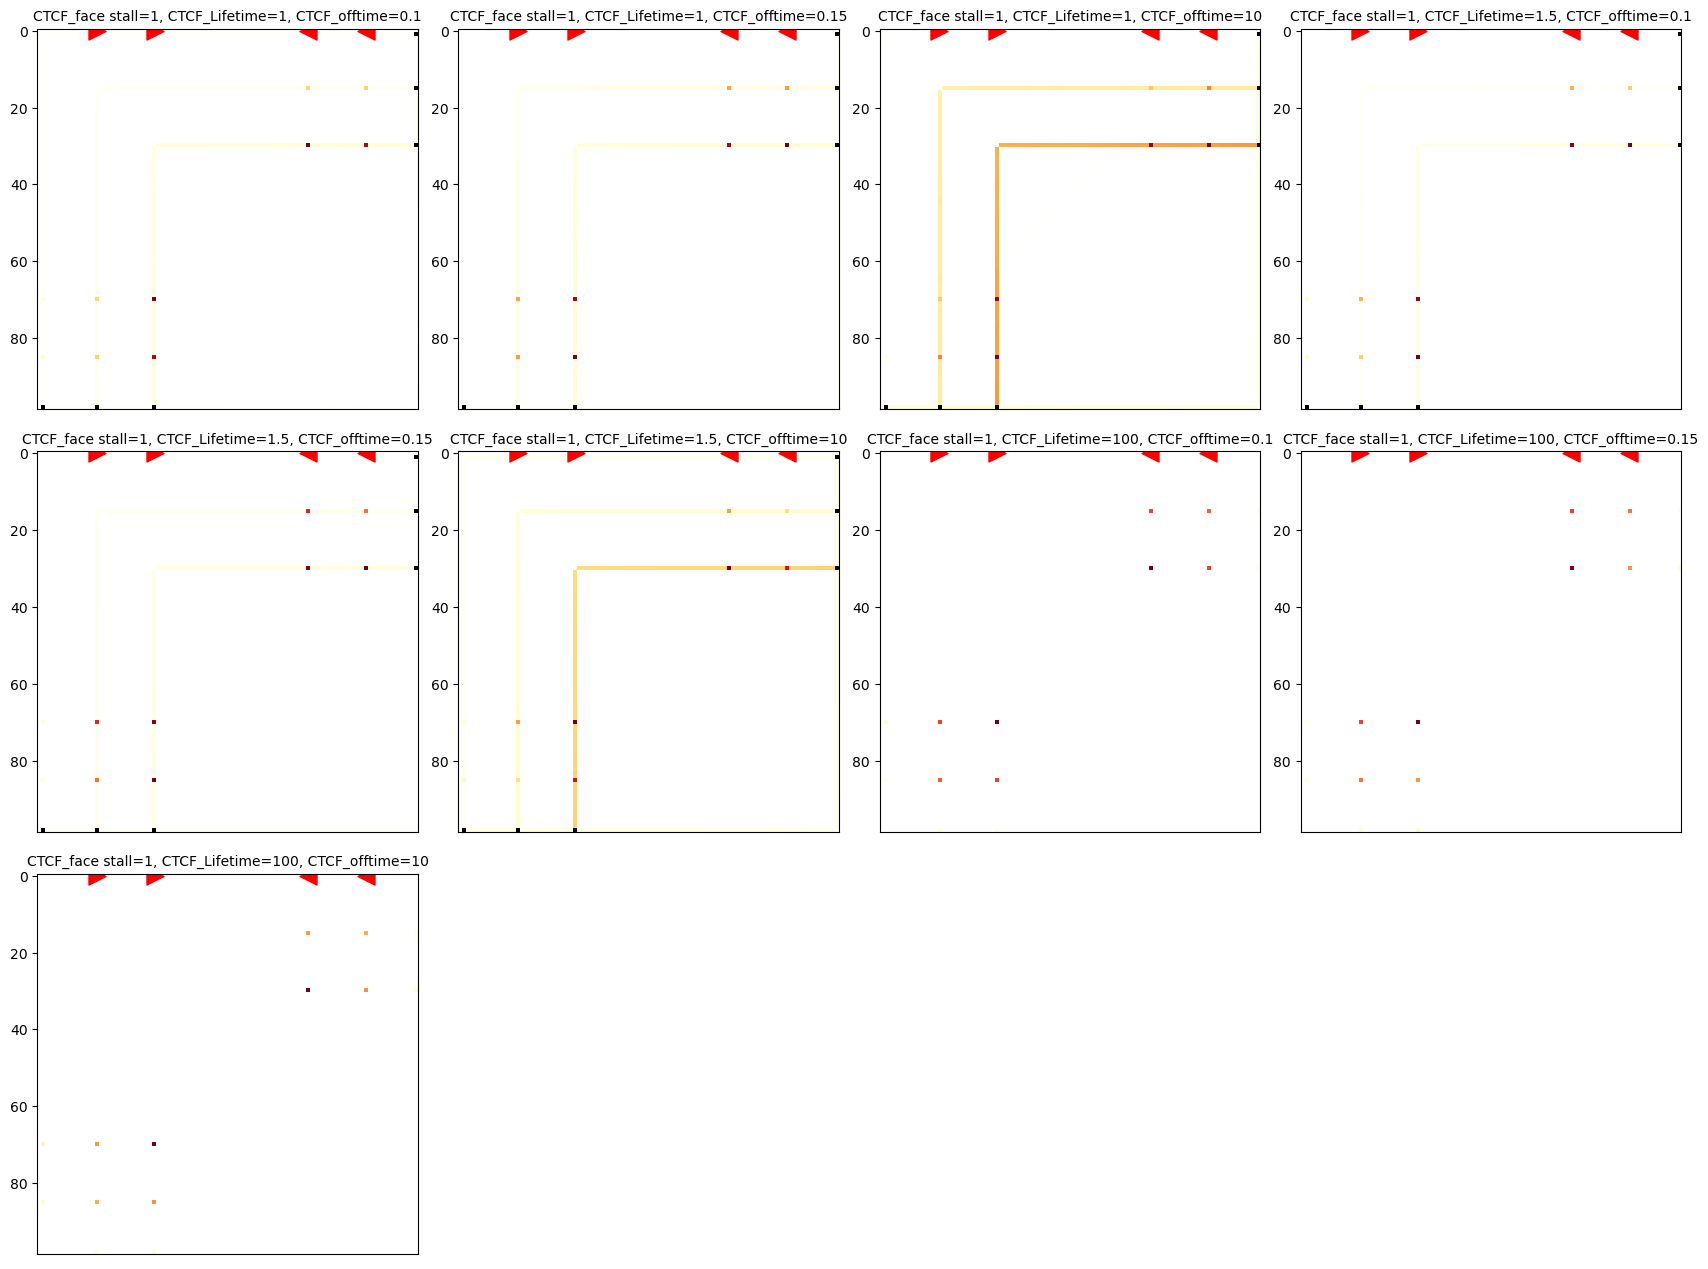

In [211]:


ctcf_life_range = [1, 1.5,  100]
ctcf_oftime_range = [0.1, 0.15,  10]
c=1
plt.figure(figsize=(17,17))
for ctcf_life in ctcf_life_range:
    for ctcf_oftime in ctcf_oftime_range:


        paramdict_CTCF['CTCF_lifetime']=[100, ctcf_life]
        paramdict_CTCF['CTCF_offtime']=[0.1, ctcf_oftime]
        
        translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                         site_types,
                                         CTCF_left_positions,
                                         CTCF_right_positions, 
                                         **paramdict_CTCF)
        
        trajectory_length = 175000
        hist = []
        plt.subplot(4,4,c)
        c +=1
        
        for _ in range(trajectory_length):
            translocator.step()
            hist.append(translocator.LEFs.copy())
        
        
        kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
        
        #print(kymograph)
        mrc  = kymograph.astype(float)
        merc = mrc/np.median(np.diag(mrc,2))
        mat = np.log10(mrc)
        #print(np.shape(mrc))
        #print(mrc)
        plt.matshow(mrc, vmax=np.max(mrc[10:90,10:90])/0.91,cmap='fall',fignum=False) 
        plt.scatter(CTCF_left_positions, [0,0], marker='>', color='red', s =150)
        plt.scatter(CTCF_right_positions, [0,0], marker='<', color='red', s =150)
                    
        plt.title('CTCF_face stall=%s, CTCF_Lifetime=%s, CTCF_offtime=%s' % (paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                          paramdict_CTCF['CTCF_offtime'][1]),
                  fontsize=10)
        
        plt.xticks([])
        plt.yticks(fontsize=10)
                
plt.tight_layout()
plt.show()                       
        

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


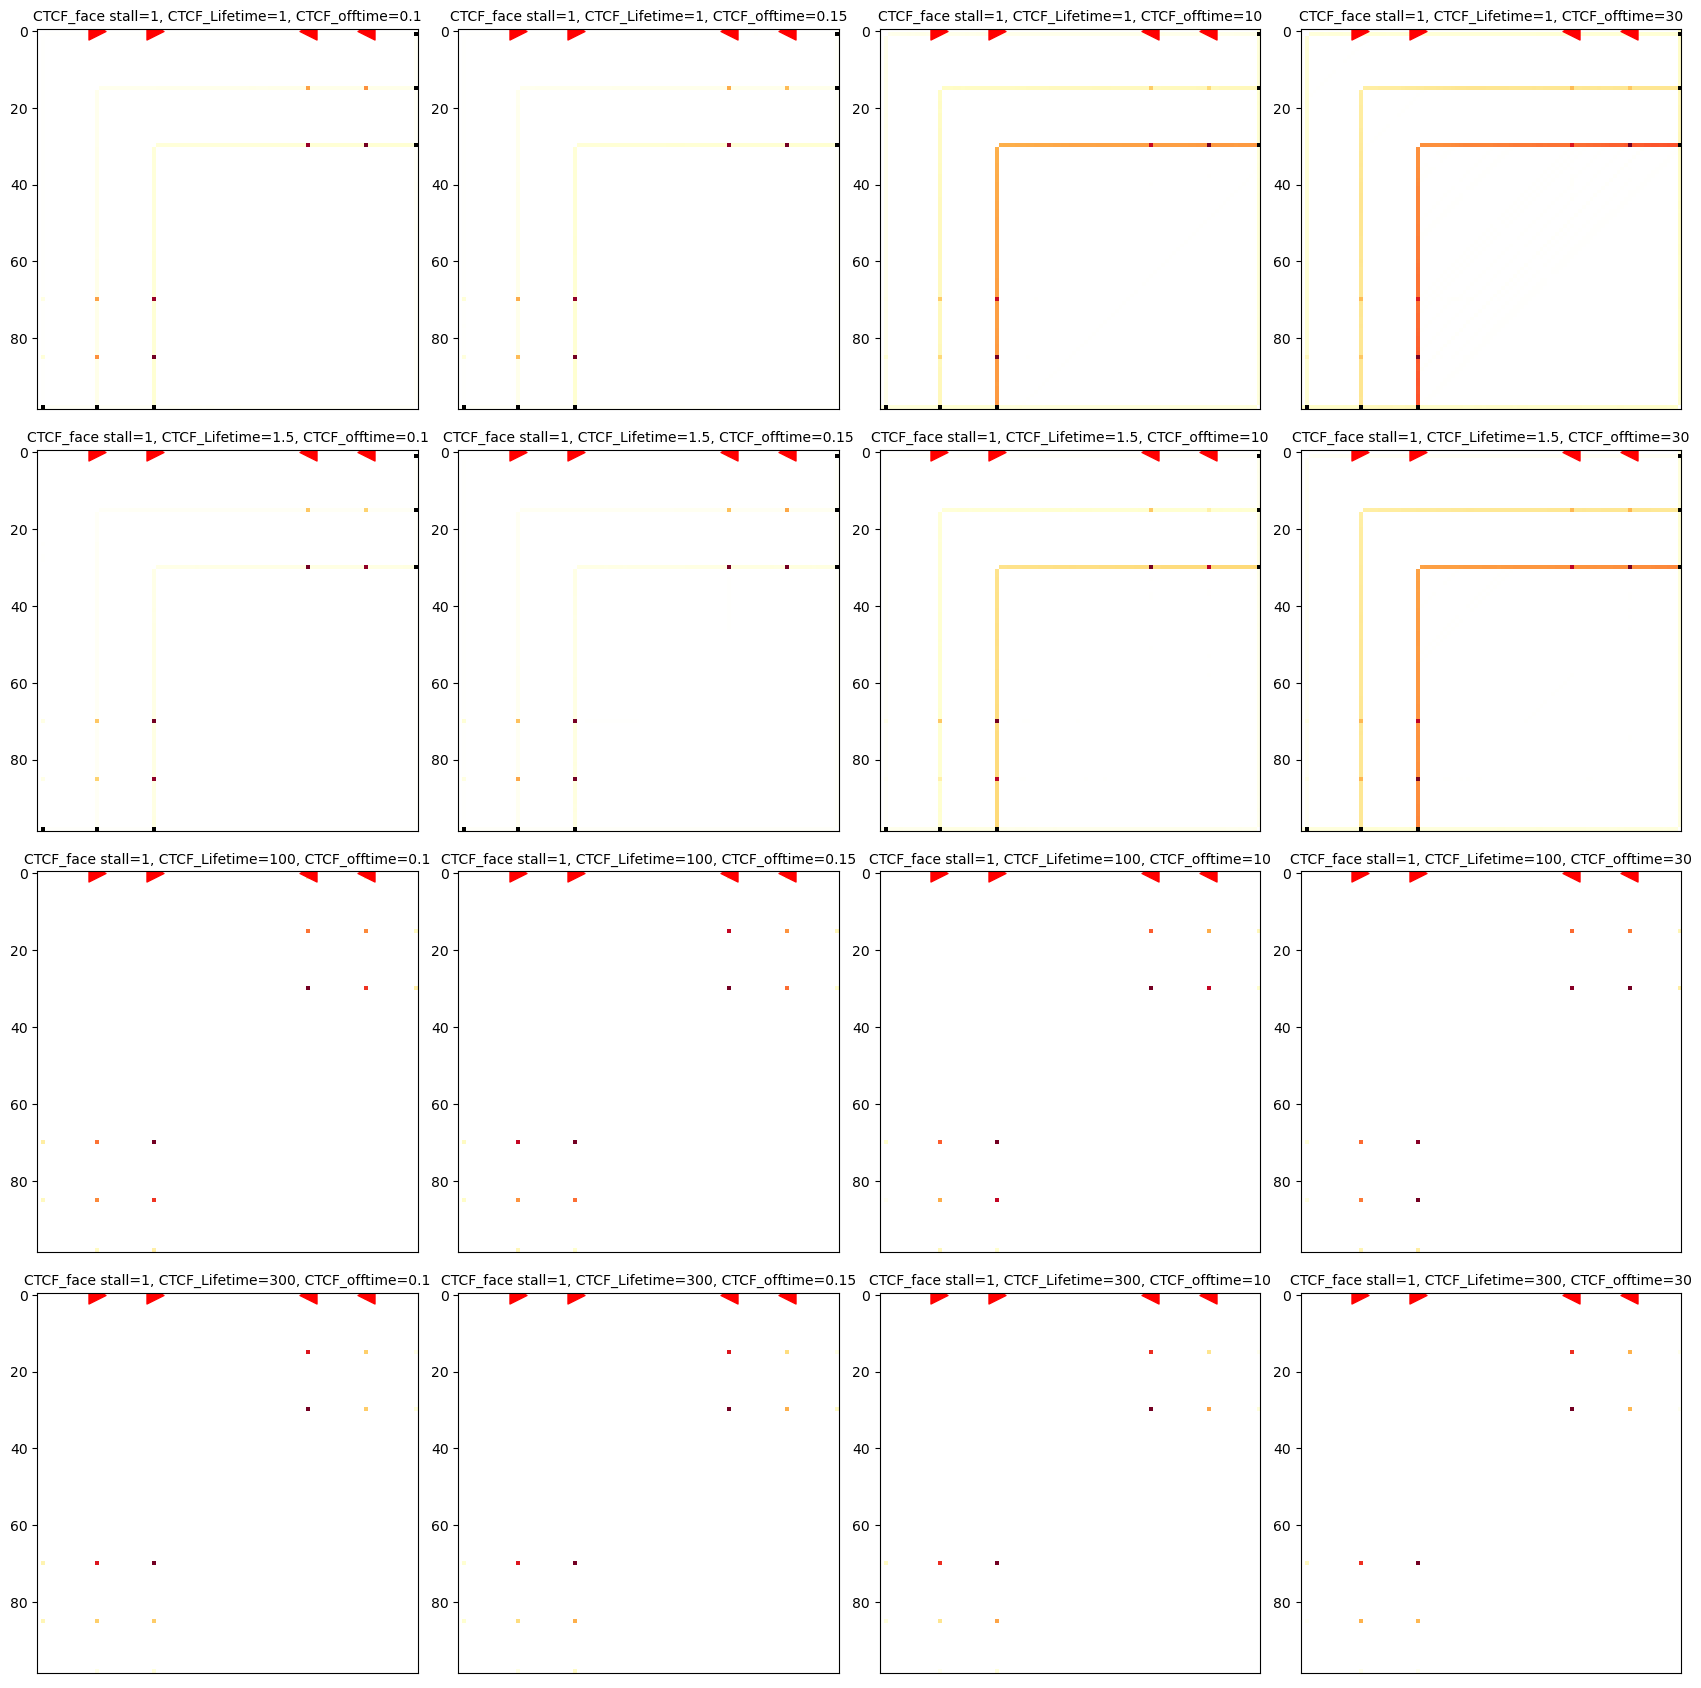

In [220]:


ctcf_life_range = [1, 1.5,  100, 300]
ctcf_oftime_range = [0.1, 0.15,  10, 30]
c=1
plt.figure(figsize=(17,17))
for ctcf_life in ctcf_life_range:
    for ctcf_oftime in ctcf_oftime_range:

        paramdict_CTCF['CTCF_facestall']=[1, 1]
        paramdict_CTCF['CTCF_lifetime']=[100, ctcf_life]
        paramdict_CTCF['CTCF_offtime']=[0.1, ctcf_oftime]
        
        translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                         site_types,
                                         CTCF_left_positions,
                                         CTCF_right_positions, 
                                         **paramdict_CTCF)
        
        trajectory_length = 300000
        hist = []
        plt.subplot(4,4,c)
        c +=1
        
        for _ in range(trajectory_length):
            translocator.step()
            hist.append(translocator.LEFs.copy())
        
        
        kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
        
        #print(kymograph)
        mrc  = kymograph.astype(float)
        merc = mrc/np.median(np.diag(mrc,2))
        mat = np.log10(mrc)
        #print(np.shape(mrc))
        #print(mrc)
        plt.matshow(mrc, vmax=np.max(mrc[10:90,10:90])/0.91,cmap='fall',fignum=False) 
        plt.scatter(CTCF_left_positions, [0,0], marker='>', color='red', s =150)
        plt.scatter(CTCF_right_positions, [0,0], marker='<', color='red', s =150)
                    
        plt.title('CTCF_face stall=%s, CTCF_Lifetime=%s, CTCF_offtime=%s' % (paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                          paramdict_CTCF['CTCF_offtime'][1]),
                  fontsize=10)
        
        plt.xticks([])
        plt.yticks(fontsize=10)
                
plt.tight_layout()
plt.show()                       
        

### static barriers

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


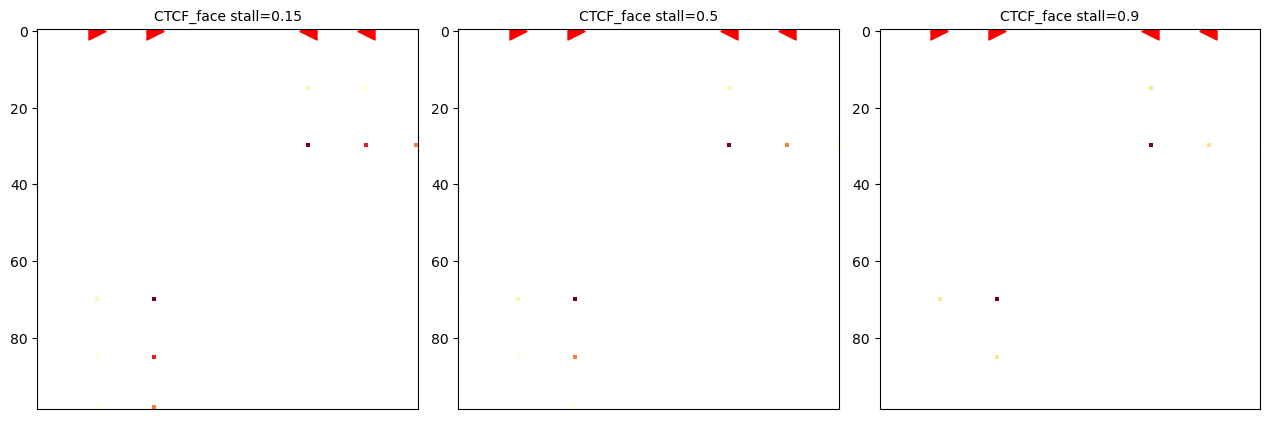

In [217]:
ctcf_life_range = [1]
ctcf_oftime_range = [0.1]
face_prob_range = [0.15, 0.5, 0.9]
c=1
plt.figure(figsize=(17,17))
CTCF_left_positions = np.array([15, 30])
CTCF_right_positions = np.array([70, 85])
for ctcf_life in ctcf_life_range:
    for face_prob in face_prob_range:


        paramdict_CTCF['CTCF_lifetime']=[100, 1]
        paramdict_CTCF['CTCF_offtime']=[0.1, 0.1]
        paramdict_CTCF['CTCF_facestall']=[1, face_prob]
        
        translocator = make_translocator(LEFTranslocator, 
                                         site_types,
                                         CTCF_left_positions,
                                         CTCF_right_positions, 
                                         **paramdict_CTCF)
        
        trajectory_length = 1000000
        hist = []
        plt.subplot(4,4,c)
        c +=1
        
        for _ in range(trajectory_length):
            translocator.step()
            hist.append(translocator.LEFs.copy())
        
        
        kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
        
        #print(kymograph)
        mrc  = kymograph.astype(float)
        merc = mrc/np.median(np.diag(mrc,2))
        mat = np.log10(mrc)
        #print(np.shape(mrc))
        #print(mrc)
        plt.matshow(mrc, vmax=np.max(mrc[10:90,10:90])/0.91,cmap='fall',fignum=False) 
        plt.scatter(CTCF_left_positions, [0,0], marker='>', color='red', s =150)
        plt.scatter(CTCF_right_positions, [0,0], marker='<', color='red', s =150)
                    
        plt.title('CTCF_face stall=%s' % (paramdict_CTCF['CTCF_facestall'][1]),
                  fontsize=10)
        
        plt.xticks([])
        plt.yticks(fontsize=10)
                
plt.tight_layout()
plt.show()                       
        